In [1]:
import time
import sys
import os
path_project = "\\".join(os.getcwd().split("\\")[:-1])
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, path_project)

from hardware.pulser.pulser import PulseGenerator, OutputState, TriggerStart, TriggerRearm, HIGH, LOW, INF
from hardware.laser.laser import LaserControl
from hardware.mw.mwsynthesizer import Synthesizer

from hardware import config as hcf

import nidaqmx
from nidaqmx.constants import TerminalConfiguration, VoltageUnits, Edge, AcquisitionType, READ_ALL_AVAILABLE
# from nidaqmx.constants import LogicFamily 
# TWO_POINT_FIVE_V, THREE_POINT_THREE_V, FIVE_V
# from nidaqmx import stream_readers 
# from nidaqmx.stream_readers import AnalogSingleChannelReader

import numpy as np
from windfreak import SynthHD
from math import floor
import time
import matplotlib.pyplot as plt

import plotly.graph_objects as go
import plotly.express as px

In [2]:
# connect to the digitizer 
from hardware.daq.sidig import FIFO_DataAcquisition
from hardware.daq.sidig import FIFO_DataAcquisition, DCCOUPLE, TERMIN_INPUT_50OHM, TERMIN_INPUT_1MOHM

SIDIG_ADDRESS = "dev/spcm0"
SIDIG_maxsr = 500e6  # Hz
SIDIG_timebase = int(1 / SIDIG_maxsr * 1e9)  # ns
dig=FIFO_DataAcquisition(
                sn_address=SIDIG_ADDRESS
            )

Clock mode set to: 32
1: Internal, 2: Quartz, 3: External, 32: Direct External Sampling


## Pulse streamer connection 

In [3]:
# connect to the pulse streamer 
pg  = PulseGenerator(ip=hcf.PS_IP, chmap=hcf.PS_chmap) 


Connect to Pulse Streamer via JSON-RPC.
IP / Hostname: 192.168.1.26
Pulse Streamer 8/2 firmware: v1.7.2
Client software: v1.7.0


## Windfreak setup

In [4]:
# connect to the windfreak mw driver 
synth = SynthHD('COM4')
synth.init()


In [5]:
ch = synth[0]  
ch.power = -60
ch.frequency = 400*1e6
ch.enable = False
synth.enable=False

## Laser control

In [6]:
laser = LaserControl(hcf.LASER_SN)
laser.open()

In [7]:
current_percent = 75.09
laser.laser_off()
laser.set_analog_control_mode("current")
laser.set_modulation_state("Pulsed")
laser.set_diode_current(current_percent, save_memory=False)

## Configure the aquistion parameters

In [8]:
f_start= (398.556-.1)/24 *1e3
f_end= (398.56+.1)/24 *1e3
step=(-f_start+f_end)/.05
# f_start= 400
# f_end= 600
# step=(-f_start+f_end)/25

In [9]:
sweep_config = {
    # WINDFREAK SETTINGSa
    "sweep_start_MHz": f_start,
    "sweep_stop_MHz": f_end,
    "sweep_step_size_MHz": .2,
    "pause_at_step_us": 100000,
    "sweep_power": 20,       # dBm
    'sweep_direction': 1 ,  # up = 1 down = 0.
    'sweep_type': 0 ,       # 0 = linear 1 = tabular 
    'sweep_only_once': True, # True = 1 rep False = inf reps
    'sweep_all_freq': False, # True = after a trigger sweep through all freq False = after trigger step 1 freq only 
    'trigger_type': 2, # 0 = software 1 = sweep 2 = step 3 = hold all 
    # 'trigger_polarity': 0, # active low =0 active high = 1,
    "trigger_mode": "single frequency step",
    # DIGITZER SETTINGS
    'readout_ch': hcf.SIDIG_chmap["apd"],
    'amp_input' : 1000,
    'terminate_input': TERMIN_INPUT_1MOHM,
    'DCCOUPLE': 0,
    'sampling_rate': hcf.SIDIG_maxsr,
    # DIGITIZER collection 
    'num_segment': 4,
    'pretrig_size': 16,
    'posttrig_size': 1024-16,
    'segment_size': 1024,
    # Loop settings
    'run_time': 10, # seconds
    'reps':1000,
    'num_mw_points':None, #assigned in next line 
    "init_time": 1e9,
    'step_switch_time': 10000, #TODO: config len 
}
sweep_config['num_samples_per_segment'] = sweep_config['pretrig_size'] + sweep_config['posttrig_size']
sweep_config['num_mw_points'] =  int( (-sweep_config['sweep_start_MHz'] + sweep_config['sweep_stop_MHz'])//sweep_config['sweep_step_size_MHz']+1)

In [10]:
# check that the mw step time is aligned with the digititzer collection time 
if (1e9/sweep_config['sampling_rate'])*sweep_config['num_samples_per_segment'] > sweep_config['pause_at_step_us']:
    print("collection is longer than the mw step time, please change the mw step time")
    raise ValueError("collection is longer than the mw step time, please change the mw step time")
else:
    pass 


## Setup the pulse sequence 

In [11]:
sweep_config['num_mw_points']

43

In [12]:
trig_len=10
step_switch_time=sweep_config['step_switch_time']-100 
readout_period=sweep_config['pause_at_step_us']+step_switch_time #TODO: config len
init_time=sweep_config['init_time'] # to avoid any error due to the windfreak setup time #TOD0: check if necessary 
ps_reps=int(sweep_config['num_mw_points']*5000) # 2 ensures that we don't wrap back around 
# ps_reps=10
# init_time=0

init_period_wdf=[(init_time,HIGH)]
init_period=[(init_time,LOW)]

freq_sweep_trig=init_period_wdf+[(sweep_config['pause_at_step_us'],HIGH),(step_switch_time,LOW)]*ps_reps #TODO: can you write this as a 10ns pulse with wait time?
# freq_sweep_trig=init_period+[(sweep_config['pause_at_step_us'],LOW),(step_switch_time,HIGH)]*ps_reps #TODO: can you write this as a 10ns pulse with wait time?


laser_trig=init_period+[(sweep_config['pause_at_step_us']/2,HIGH),(step_switch_time/2,LOW),(sweep_config['pause_at_step_us']/2,HIGH),(step_switch_time/2,LOW)]*ps_reps #TODO: config len
# switch_trig=init_period+[(1e9*20,HIGH)]
switch_trig=init_period+[(readout_period/2-3*trig_len,HIGH),(readout_period/2+3*trig_len,LOW)]*ps_reps # "always" on, off at end to avoid dig freq filter #TODO: config len
dig_trig=init_period+[(trig_len,HIGH),(readout_period/2 - trig_len,LOW)]*2*ps_reps #TODO: config len


pg.setDigital("WDF", freq_sweep_trig)
pg.setDigital("mwA", switch_trig) # TODO: add channel for the switch
pg.setDigital("laser", laser_trig)
pg.setDigital("sdtrig", dig_trig)

pg.setTrigger(TriggerStart.SOFTWARE, rearm=TriggerRearm.AUTO)
# REPEAT_INFINITELY = -1
# pg.stream(n_runs=1)
# pg.plotSeq(plot_all=False)


In [13]:
pg.stream(n_runs=1) #, wait_for_trigger=True, trigger=TriggerStart.SOFTWARE, rearm=TriggerRearm.AUTO)

In [14]:
# # add to code if necessary 
# # Disable pulsing -- need to reset from previoius trial run 
# ch.write('pulse_cont', False)
# # ch.write('pulse_single', 0)
# ch.write('pulse_num_rep', 0)
# ch.write('pulse_on_time', 0)
# ch.write('pulse_off_time', 0)


In [15]:
sweep_config['sweep_start_MHz'] 
sweep_config['sweep_stop_MHz']  # MHz

16610.833333333336

In [16]:
# step with ext trigger V4 
# yes works by gated on high and low pulse from the pulse streamer 
synth[0].power = 20
# ch.frequency = 400*1e6

ch.write('frequency',sweep_config['sweep_start_MHz'])
ch.write('sweep_freq_low', sweep_config['sweep_start_MHz'])
ch.write('sweep_freq_high', sweep_config['sweep_stop_MHz'])
ch.write('sweep_freq_step', sweep_config['sweep_step_size_MHz'])
ch.write('sweep_time_step',100) #TODO check if this is necessary in stepped version
ch.write('sweep_power_low', sweep_config['sweep_power'])
ch.write('sweep_power_high', sweep_config['sweep_power'])
ch.write('sweep_direction', sweep_config['sweep_direction'])
ch.write('sweep_diff_freq', 0)
ch.write('sweep_diff_meth', 0)
ch.write('sweep_type', sweep_config['sweep_type'])
ch.write('sweep_cont', sweep_config['sweep_only_once'])
ch.write('sweep_single', sweep_config['sweep_all_freq'])
synth.enable_trigger=sweep_config['trigger_type'] # 0 = software 1 = sweep 2 = step 3 = hold all 
# synth.trigger_polarity=sweep_config['trigger_polarity'] # active low =0 active high = 1
synth.trigger_mode= sweep_config['trigger_mode']
 
# synth.rf_enable = True # not necessary
# ch.rf_enable = True # not necessary


# synth.sweep_enable = True 3 not necessary either 
# ch.sweep_enable = Truea

### Digitzer config setup

In [17]:
# To set the configuration, make a dictionary with the key and value
# TODO: config the parameters for the digitizer
dig.reset_param()
dig.assign_param(dict(
             readout_ch=sweep_config['readout_ch'], 
             amp_input=sweep_config['amp_input'], 
             num_segment=sweep_config['num_segment'],
             pretrig_size=sweep_config['pretrig_size'],
             posttrig_size=sweep_config['posttrig_size'],
             segment_size=sweep_config['segment_size'],
             terminate_input=sweep_config['terminate_input'],
             DCCOUPLE = sweep_config['DCCOUPLE'],
             sampling_rate=sweep_config['sampling_rate'],
            #  terminate_input=TERMIN_INPUT_50OHM, #TODO: check this - why is it commented out
             ))

In [18]:
dig.set_config()

In [19]:
# start_time = time.time()
# # laser.laser_on()
# dig.set_config()
# dig.start_buffer()
# pg.startNow()
# ch.enable = True 
# synth.enable=True
# idx_pointer=0
# reps=0

# while (time.time() - start_time) < sweep_config['run_time']:
#     raw_data= dig.stream()
#     if raw_data is not None:
#         raw_data = np.squeeze(raw_data, axis=-1)
#         num_segs = np.shape(raw_data)[0]
#         assert num_segs % 2 == 0
#         if idx_pointer + num_segs//2 < (sweep_config['num_mw_points']-1):
#             print("loop1, idx_start",idx_pointer)
#             mw_on[:,idx_pointer:idx_pointer+num_segs//2] = raw_data[0::2,:] 
#             mw_off[:,idx_pointer:idx_pointer+num_segs//2] = raw_data[1::2,:]
#             idx_pointer += num_segs//2
#             print("loop1, idx_end",idx_pointer)
#         if idx_pointer + num_segs//2 == (sweep_config['num_mw_points']-1):
#             print("loop2, idx_start",idx_pointer)
            
#             # tail_num=(sweep_config['num_mw_points']-1)-idx_pointer
#             # leading_num=num_segs//2-tail_num
#             # print("tail_num",tail_num)
#             # print("leading_num",leading_num)
#             print(len(raw_data))
#             mw_on[:,idx_pointer:] += raw_data[0,:]
#             mw_off[:,idx_pointer:] += raw_data[1,:]
#             if len(raw_data) > 2:
#                 mw_on[:,0:idx_pointer-1] += raw_data[2::2,:]
#                 mw_off[:,0:idx_pointer-1] += raw_data[3::2,:]
            
#             idx_pointer += num_segs//2
#             idx_pointer = idx_pointer % (sweep_config['num_mw_points']-1)
#             reps += 1
#             print("loop2, idx_end",idx_pointer)
#         if idx_pointer + num_segs//2 > (sweep_config['num_mw_points']-1):
#             print("loop3, idx_start",idx_pointer)
            
#             tail_num=(sweep_config['num_mw_points']-1)-idx_pointer
#             leading_num=num_segs//2-tail_num
#             print("tail_num",tail_num)
#             print("leading_num",leading_num)
#             mw_on[:,idx_pointer:] += raw_data[0:tail_num*2:2,:]
#             mw_off[:,idx_pointer:] += raw_data[1:tail_num*2:2,:]

#             mw_on[:,0:leading_num] += raw_data[tail_num::2,:]
#             mw_off[:,0:leading_num] += raw_data[tail_num+1::2,:]
            
#             idx_pointer += num_segs//2
#             idx_pointer = idx_pointer % (sweep_config['num_mw_points']-1)
#             reps += 1
#             print("loop3, idx_end",idx_pointer)
    

## Run ODMR 

In [20]:
# mw_on = np.zeros((sweep_config['segment_size'], sweep_config['num_mw_points']))
# mw_off = np.zeros((sweep_config['segment_size'], sweep_config['num_mw_points']))
mw_on = np.zeros((sweep_config['num_mw_points'], sweep_config['segment_size']))
mw_off = np.zeros((sweep_config['num_mw_points'], sweep_config['segment_size']))
# start_time = time.taime()
# laser.laser_off()


# pg.setTrigger(SoftwareTrigger=TriggerRearm.AUTO)
idx_pointer = 0
reps = 0


laser.laser_on()
dig.set_config()
dig.start_buffer()
pg.startNow()

ch.enable = True 
synth.enable=True

while (reps < 5000):
    raw_data = dig.stream()

    if raw_data is not None:
        raw_data = np.squeeze(raw_data, axis=-1)
        num_segs = raw_data.shape[0]
        assert num_segs % 2 == 0
        for i in range(num_segs//2):
            idx = (idx_pointer + i) % (sweep_config['num_mw_points']-1)
            mw_on[idx, :] += np.ravel(raw_data[2*i,:])
            mw_off[idx, :] += np.ravel(raw_data[2*i+1,:])

        idx_pointer += num_segs//2
        if idx_pointer >= (sweep_config['num_mw_points']-1):
            reps += 1

        idx_pointer = idx_pointer % (sweep_config['num_mw_points']-1)


        # num_mw_points = num_segs // 2
        # remaining_space = sweep_config['num_mw_points'] - idx_pointer - 1
        
        # if remaining_space == 0:
    
        #     # Handle full wrap-around
        #     mw_on[0:num_mw_points, :] += raw_data[0::2, :]
        #     mw_off[0:num_mw_points,:] += raw_data[1::2, :]
        #     idx_pointer = num_mw_points
        #     reps += 1
        # elif num_mw_points <= remaining_space:
        #     # No wrap-around needed
        #     mw_on[idx_pointer:idx_pointer+num_mw_points,:] += raw_data[0::2, :] 
        #     mw_off[idx_pointer:idx_pointer+num_mw_points,:] += raw_data[1::2, :]
        #     idx_pointer += num_mw_points
        # else:
        #     # Partial wrap-around
        #     tail_num = remaining_space
        #     leading_num = num_mw_points - tail_num
            
        #     # Process tail (end of array)
        #     mw_on[idx_pointer:,:] += raw_data[0:tail_num*2:2, :]
        #     mw_off[idx_pointer:,:] += raw_data[1:tail_num*2:2, :]
            
        #     # Process leading (start of array)
        #     mw_on[0:leading_num,:] += raw_data[tail_num*2::2, :]
        #     mw_off[0:leading_num,:] += raw_data[tail_num*2+1::2, :]
            

        #     idx_pointer = leading_num
        #     reps += 1

laser.laser_off()
dig.stop_card()
ch.enable = False
synth.enable=False 
pg.forceFinal()

pg.reset()


Card stopped


In [21]:
# ch.enable = False
# synth.enable=False 
# pg.forceFinal()

# pg.reset()

In [22]:
# # disable all the inst 
# dig.stop_card()
ch.enable = False
synth.enable=False
pg.forceFinal()
pg.reset()  
# laser.laser_off()


## Data Processing 

In [23]:
frequncies = np.arange(sweep_config['sweep_start_MHz'], sweep_config['sweep_stop_MHz'] + sweep_config['sweep_step_size_MHz'], sweep_config['sweep_step_size_MHz'])
frequncies

array([16602.33333333, 16602.53333333, 16602.73333333, 16602.93333333,
       16603.13333333, 16603.33333333, 16603.53333333, 16603.73333333,
       16603.93333333, 16604.13333333, 16604.33333333, 16604.53333333,
       16604.73333333, 16604.93333333, 16605.13333333, 16605.33333333,
       16605.53333333, 16605.73333333, 16605.93333333, 16606.13333333,
       16606.33333333, 16606.53333333, 16606.73333333, 16606.93333333,
       16607.13333333, 16607.33333333, 16607.53333333, 16607.73333333,
       16607.93333333, 16608.13333333, 16608.33333333, 16608.53333333,
       16608.73333333, 16608.93333333, 16609.13333333, 16609.33333333,
       16609.53333333, 16609.73333333, 16609.93333333, 16610.13333333,
       16610.33333333, 16610.53333333, 16610.73333333, 16610.93333333])

In [24]:
def avg(mw_on,mw_off,start,stop):
    on_splice=np.copy(mw_on[:,start:stop])
    off_splice=np.copy(mw_off[:, start:stop])
    return (np.mean(on_splice,axis=1),np.mean(off_splice,axis=1))

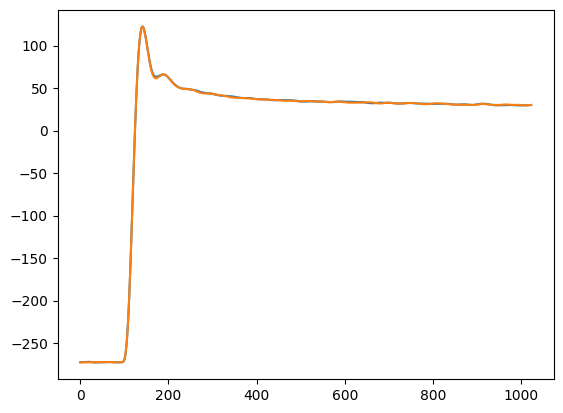

In [25]:
plt.plot(mw_on[30])
plt.plot(mw_off[30])

In [26]:
on_avg, off_avg = avg(mw_on,mw_off,100,300)

In [27]:
mw_on[100:200]

array([], shape=(0, 1024), dtype=float64)

In [28]:
# Create the figure
fig = go.Figure()

# Add a trace (line plot)
# fig.add_trace(go.Scatter(
#     x=frequncies*24,
#     y=on_avg,
#     mode='lines+markers',
#     name='MW On',
#     line=dict(color='blue', width=2),
#     marker=dict(size=6)
# ))

# fig.add_trace(go.Scatter(
#     x=frequncies*24,
#     y=off_avg,
#     mode='lines+markers',
#     name='MW Off',
#     line=dict(color='red', width=2),
#     marker=dict(size=6)
# ))

fig.add_trace(go.Scatter(
    x=frequncies*24,
    y=off_avg-on_avg,
    mode='lines+markers',
    name='Contrast',
    # line=dict(color='red', width=2),
    marker=dict(size=6)
))

# Customize layout
fig.update_layout(
    title='MW On/Off Average',
    xaxis_title='frequency (MHz)',
    yaxis_title='PL (arb units)',
    template='plotly_white',  # Try 'plotly_dark', 'ggplot2', 'seaborn', etc.
    font=dict(family='Arial', size=14),
    width=700,
    height=450,
    margin=dict(l=60, r=40, t=60, b=60)
)

# Show the plot
fig.show()